In [1]:
import PIL
from os import listdir
from os.path import isfile, join
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
def get_all_images(filepath): #Function to get all .png files from directory consisting subset of dataset
    return [f for f in listdir(filepath) if isfile(join(filepath, f))]

In [3]:
def get_images(filepath):
    res = get_all_images(filepath)
    images = []
    for i in range(len(res)):
        im = PIL.Image.open(filepath + '/' + res[i])
        width, height = im.size
        im = im.crop((400,100,width,height))
        im = im.resize((150,150))
        im = ImageOps.grayscale(im)
        images.append(im)
    return images

In [4]:
autoRifles = get_images("ImageSets/AutoRifles")
pulseRifles = get_images("ImageSets/PulseRifles")
scoutRifles = get_images("ImageSets/ScoutRifles")

In [14]:
def save_observations(observations):   
    res = []
    for el in observations:
        im = np.array(el)
        size = np.shape(el)
        im = np.reshape(im,size[0]*size[1])
        res.append(im)
    return np.array(res)

observations = {
    'auto' : save_observations(autoRifles),
    'pulse': save_observations(pulseRifles),
    'scout': save_observations(scoutRifles)    
}

In [15]:
allObservations = np.copy(observations['auto'])
allObservations = np.append(allObservations,observations['pulse'],axis=0)
allObservations = np.append(allObservations,observations['scout'],axis=0)

In [6]:
names = ['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI','XVII','XVIII','XIX','X']

for i in range (len(autoRifles)):
    autoRifles[i].save('ImageSets/AutoRiflesConverted/'+ names[i] + '.png')
    pulseRifles[i].save('ImageSets/PulseRiflesConverted/'+ names[i] + '.png')
    scoutRifles[i].save('ImageSets/ScoutRiflesConverted/'+ names[i] + '.png')

In [19]:
res = np.cov(allObservations) #Covariance matrix before using PCA

In [20]:
np.savetxt("CovarianceMatrices/covarianceBefore.csv",res,delimiter=";")

# Wariancje

In [21]:
pca = PCA()

In [22]:
pca.fit(allObservations)

PCA()

In [23]:
resAfter = np.cov(pca.fit_transform(allObservations))

In [24]:
def plot_variance(covMatrix):
    n = np.shape(covMatrix)[0]
    X = []
    variance = []
    for i in range(n):
        X.append(i+1)
        variance.append(covMatrix[i][i])
    
    plt.rcParams["figure.figsize"] = (16,9)
    plt.scatter(X,variance, color='orange')
    plt.xlabel("Dana określona cecha")
    plt.ylabel("Wartość wariancji dla określonej cechy")

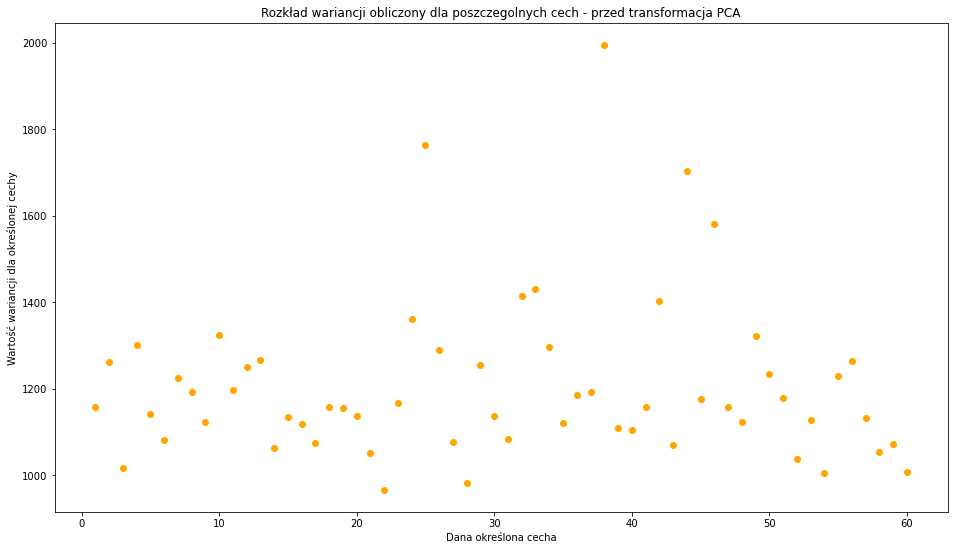

In [28]:
plt.title("Rozkład wariancji obliczony dla poszczegolnych cech - przed transformacja PCA")
plot_variance(res)

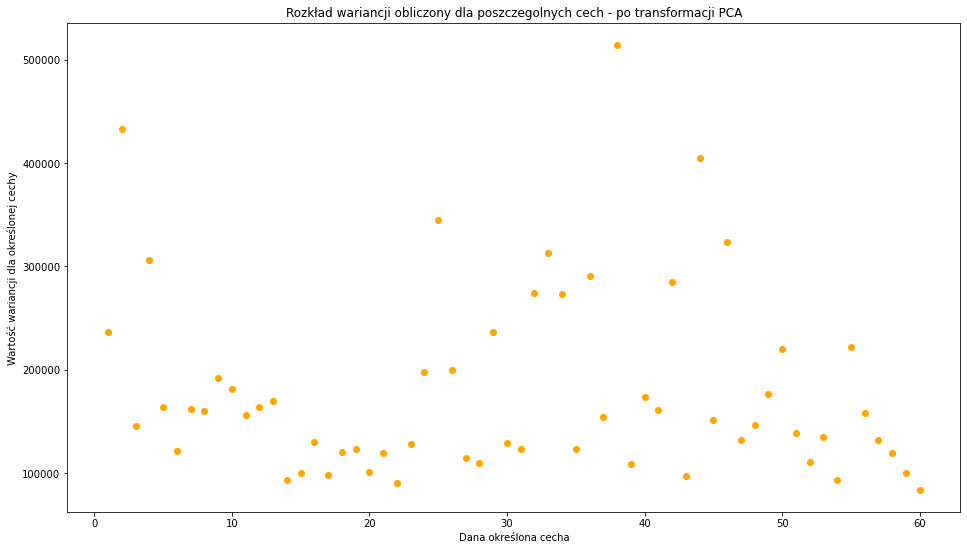

In [29]:
plt.title("Rozkład wariancji obliczony dla poszczegolnych cech - po transformacji PCA")
plot_variance(resAfter)

# Macierze kowariancji

In [30]:
np.savetxt("CovarianceMatrices/covarianceAfter.csv",resAfter,delimiter=";")

Text(123.0, 0.5, 'Wiersz w macierzy kowariancji')

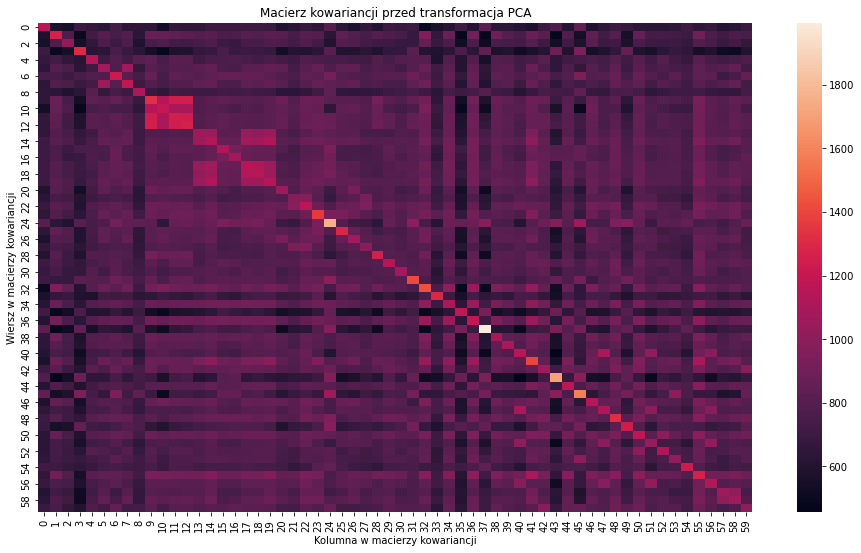

In [31]:
sns.heatmap(res).set(title='Macierz kowariancji przed transformacja PCA')
plt.xlabel('Kolumna w macierzy kowariancji')
plt.ylabel('Wiersz w macierzy kowariancji')

Text(123.0, 0.5, 'Wiersz w macierzy kowariancji')

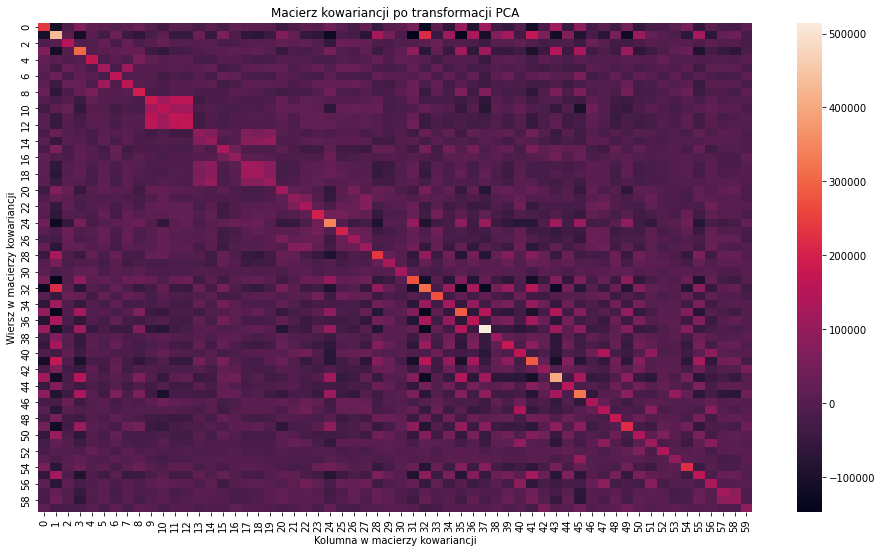

In [32]:
sns.heatmap(resAfter).set(title='Macierz kowariancji po transformacji PCA')
plt.xlabel('Kolumna w macierzy kowariancji')
plt.ylabel('Wiersz w macierzy kowariancji')

# Średnie zdjęcia

In [33]:
observationsMean = pca.mean_

In [35]:
photoMean = np.reshape(observationsMean,(150,150))

In [37]:
meanim = Image.fromarray(photoMean).convert("L")
meanim.save('ImageSets/meanImage.png')

# Wektory bazowe

In [38]:
basicVectors = pca.components_

In [39]:
def visualize_components(path,components):
    n = np.shape(components)[0]
    for i in range(n):
        vector = components[i]
        vector = np.reshape(vector,(150,150))
        im = Image.fromarray(vector).convert("L")
        im.save(path + str(i) + '.png')

In [40]:
visualize_components('ImageSets/BasicComponents/',basicVectors)

# Redukcja wymiarów

In [42]:
def get_most_important_features(covariance,amount):
    n = np.shape(covariance)[0]
    variance = []
    features = []
    for i in range(n):
        variance.append((covariance[i][i],i))
    variance = sorted(variance,key=lambda p:p[0],reverse=True)
    for i in range(amount):
        features.append(variance[i][1])
        
    return features

def apply_zero_reduction(observations,features):
    n = np.shape(observations)
    for i in range(n[0]):
        for j in range(n[1]):
            if j not in features:
                observations[i][j] = 0
    return observations

In [46]:
featuresAmount = [3,9,27]
for el in featuresAmount:
    features = get_most_important_features(resAfter,el)
    data = apply_zero_reduction(pca.fit_transform(allObservations),features)
    data = pca.inverse_transform(data)
    visualize_components("ImageSets/ReducedImages/" + str(el) + "Features/",data)

# Mapowanie 2D

In [47]:
pca = PCA(n_components=2)

In [48]:
observations2D = pca.fit_transform(allObservations)

In [49]:
def convertIntoCoordinates(observations):
    X = []
    Y = []
    for i in range(np.shape(observations)[0]):
        X.append(observations[i][0])
        Y.append(observations[i][1])
    return X,Y

In [50]:
autoCords = convertIntoCoordinates(observations2D[:20])
pulseCords = convertIntoCoordinates(observations2D[20:40])
scoutCords = convertIntoCoordinates(observations2D[40:60])

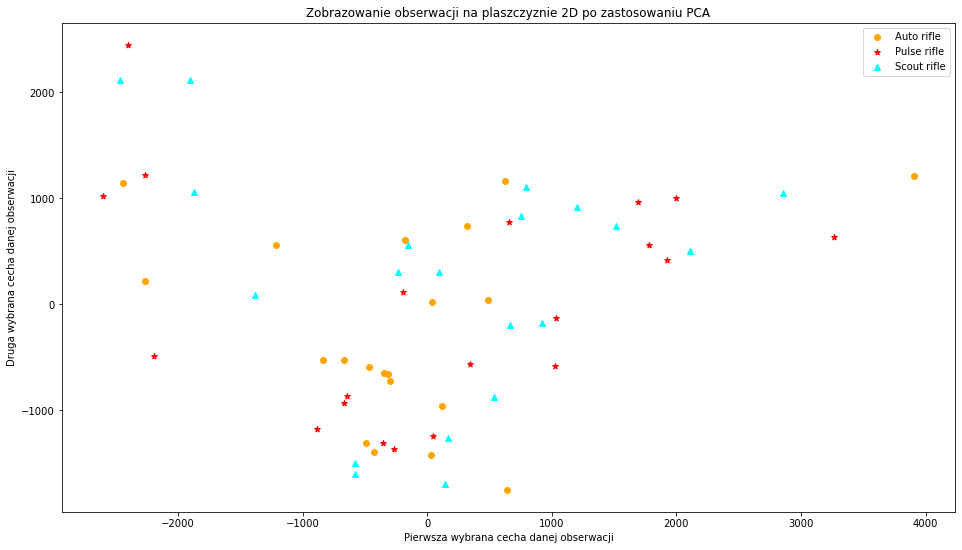

In [51]:
plt.rcParams["figure.figsize"] = (16,9)
plt.xlabel("Pierwsza wybrana cecha danej obserwacji")
plt.ylabel("Druga wybrana cecha danej obserwacji")
plt.title("Zobrazowanie obserwacji na plaszczyznie 2D po zastosowaniu PCA")
plt.scatter(autoCords[0],autoCords[1],label = 'Auto rifle',marker = 'o', color='orange')
plt.scatter(pulseCords[0],pulseCords[1],label = 'Pulse rifle',marker = '*', color='red')
plt.scatter(scoutCords[0],scoutCords[1],label = 'Scout rifle',marker = '^', color='cyan')
plt.legend()
plt.show()